# == Pre-trained CNN Four classes Classification with Data Augmentation==

In [ ]:
# Computational Intelligence Project
# Dipartimento di Ingegneria dell´Informazione , Universita´ di Pisa
# Authors: Rachele Nebbia Colomba, Alessandro Gentili, Giorgio Simonini
#    begin                : June 2020
#    copyright            : (C)  2020 Universita´ di pisa    
#    email                : rachelenebbia <at> gmail <dot> com

# Import libraries 
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
print(keras.__version__)
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import os
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
from google.colab import drive
from tensorflow.keras.models import load_model


TensorFlow 1.x selected.
1.15.2
2.2.4-tf


Using TensorFlow backend.


In [ ]:
def mischia(img,lab):
    z=list(zip(img,lab)) #zip returns an iterator instead and needs to be passed to a list function to get the zipped tuples
    rnd.shuffle(z) #random shuffle of the tuples
    img2,lab2=zip(*z) #unzipping, it obtaines the original form 
    img2=np.asarray(img2)
    lab2=np.asarray(lab2)
    return img2,lab2

In [ ]:
# Import data
drive.mount('/content/drive/')

dir_numpy ="/content/drive/My Drive/Computational/numpy data"
dir_nets ="/content/drive/My Drive/Computational/networks"
dir_check ="/content/drive/My Drive/Computational/networks"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


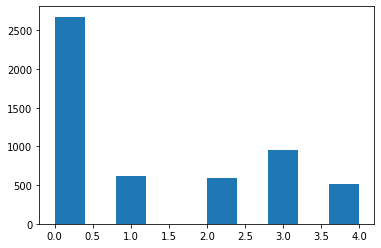

5352 images


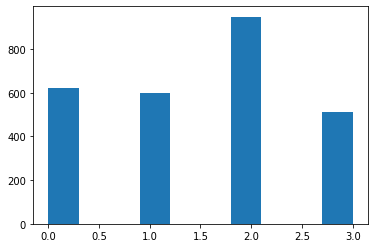

2676 images


In [ ]:
# Load tensor for Training Dataset (images+labels) and Testing Dataset (images+labels)
train_img = np.load(os.path.join(dir_numpy,'train_tensor.npy'))
train_lab = np.load(os.path.join(dir_numpy,'train_labels.npy'))
test_img = np.load(os.path.join(dir_numpy,'public_test_tensor.npy'))
test_lab = np.load(os.path.join(dir_numpy,'public_test_labels.npy'))

# Plot histogram to visualize classes distribution of Dataset
plt.hist(train_lab)
plt.show()
print(len(train_lab), "images")
# Here define new tensors to divide between masses and calcifications
# Labels legend --> 0,1 = bening and malign masses; 2,3 = malign calcifications.
n_img=len(train_img)
train_img_22=train_img[1:n_img:2]
n_img_test=len(test_img)
test_img_22=test_img[1:n_img_test:2]
# From tensor get labels
train_lab_22=train_lab[1:n_img:2]
test_lab_22=test_lab[1:n_img_test:2]
n_img22=len(train_img_22)
n_img22_test=len(test_img_22)
train_lab_22 = train_lab_22 - 1
test_lab_22 = test_lab_22 - 1
#Plot histogram to visualize data distribution 
plt.hist(train_lab_22)
plt.show()
print(len(train_lab_22), "images")

float32


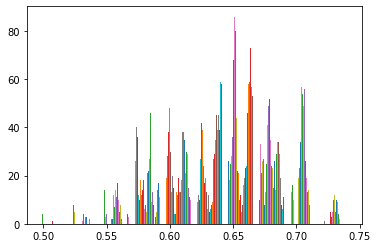

(336, 150, 150, 1)

In [ ]:
# Normalize train and test images 
train_img_22 = train_img_22.astype('float32') / 65535
test_img_22 = test_img_22.astype('float32') / 65535

# Visualize processing
print(train_img_22[5,:].dtype) # check the type
plt.hist(train_img_22[5,:]) # check the value range and the distribution
plt.show()

# Reshape datasets
train_img_22 = train_img_22.reshape((n_img22, 150, 150, 1))
test_img_22 = test_img_22.reshape((n_img22_test, 150, 150, 1))
# Check tensor
test_img_22.shape

In [ ]:
##shuffle samples to have random order of classes
train_lab_22 = to_categorical(train_lab_22)
test_lab_22 = to_categorical(test_lab_22)
train_lab_22.shape
print(train_lab_22[0:2000])

[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [ ]:
# reshap train dataset 
train_img_22, train_lab_22 = mischia(train_img_22, train_lab_22)
train_lab_22.shape
print(train_lab_22[0:2000])

[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


In [ ]:
# Data augmentation
BATCH_SIZE = 200
# Select images to perform data aug
val_img_22 = train_img_22[2400:2675]
val_lab_22 = train_lab_22[2400:2675]
train_img_22b = train_img_22[0:2399]
train_lab_22b = train_lab_22[0:2399]

# Generate new images with rotation and flip of dataset images 
train_datagen = ImageDataGenerator(
    rotation_range=180,
    zoom_range=0.1,
    horizontal_flip=True)

val_datagen = ImageDataGenerator()

# Note that the validation data should not be augmented!

train_generator = train_datagen.flow(
        train_img_22b,
        train_lab_22b,
        batch_size=BATCH_SIZE)

validation_generator = val_datagen.flow(
        val_img_22,
        val_lab_22,
        batch_size=BATCH_SIZE)


In [ ]:
# Design of the CNN 
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________

In [ ]:
#Compile with chosen optimizer and metrics 
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Define parameters: epochs, validation split, batch size and checkpoints
file_check ="/content/drive/My Drive/Computational/networks/checkpoint22b"
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=10)
checkpoint = ModelCheckpoint(file_check, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit_generator(
      train_generator,
      steps_per_epoch=2400//BATCH_SIZE,
      epochs=150,
      validation_data=validation_generator,
      validation_steps=276//BATCH_SIZE,
      callbacks=[checkpoint],
      shuffle = True)


Epoch 1/150
 1/12 [=>............................] - ETA: 3s - loss: 1.3719 - acc: 0.3350
Epoch 00001: val_acc improved from -inf to 0.33500, saving model to /content/drive/My Drive/Computational/networks/checkpoint22b
12/12 [==============================] - 18s 2s/step - loss: 1.3861 - acc: 0.3251 - val_loss: 1.3719 - val_acc: 0.3350
Epoch 2/150
 1/12 [=>............................] - ETA: 1s - loss: 1.3687 - acc: 0.3350
Epoch 00002: val_acc did not improve from 0.33500
12/12 [==============================] - 6s 503ms/step - loss: 1.3794 - acc: 0.3572 - val_loss: 1.3687 - val_acc: 0.3350
Epoch 3/150
 1/12 [=>............................] - ETA: 1s - loss: 1.3645 - acc: 0.3350
Epoch 00003: val_acc did not improve from 0.33500
12/12 [==============================] - 6s 514ms/step - loss: 1.3631 - acc: 0.3572 - val_loss: 1.3645 - val_acc: 0.3350
Epoch 4/150
 1/12 [=>............................] - ETA: 1s - loss: 1.3571 - acc: 0.3350
Epoch 00004: val_acc did not improve from 0.33500


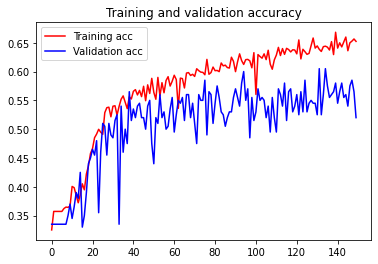

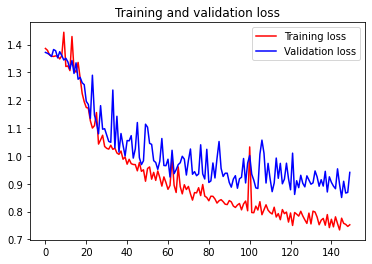

In [ ]:
# Visualize Results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plot training and validation accuracy 
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()


# Plot training and validation loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate results on Test Dataset
test_loss, test_acc = model.evaluate(test_img_22, test_lab_22)

336/336 [==============================] - 1s 2ms/sample - loss: 1.0822 - acc: 0.5208


In [ ]:
#ckmodel.save(os.path.join(dir_nets,"net_22b.h5"))

In [ ]:
ckmodel = load_model(os.path.join(dir_check,"checkpoint22b"))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
# Evaluate results on Test Dataset from check point 
test_loss, test_acc = ckmodel.evaluate(test_img_22, test_lab_22)

336/336 [==============================] - 0s 1ms/sample - loss: 0.9411 - acc: 0.5714


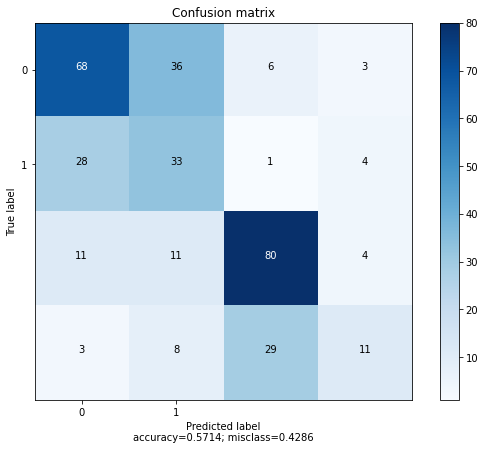

In [ ]:
# Visualize results: Confusion Matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
#Plotting of the Matrix confusion
def plot_confusion_matrix(cm,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
  
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
 
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    cmap = plt.get_cmap('Blues')
 
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
 
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xticks(range(0,2),)
    plt.yticks(range(0,2),)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
 
pred_22=np.argmax(ckmodel.predict(test_img_22),axis =1)
true_22=np.argmax(test_lab_22,axis = 1)
metrics.confusion_matrix(true_22,preds_22)

# y_pred=ckmodel.predict(test_img_22)
#for i in range(len(y_pred)): 
#  j = np.argmax(pred_22[i])
#  pred_22[i]= np.zeros(4)
#  pred_22[i][j] = 1
conf_mtx = confusion_matrix(true_22, pred_22) 
plot_confusion_matrix(conf_mtx,normalize=False)